In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

from Qatmosphere_2d import Atmosphere_Maps

import sys
import yaml

sys.path.append('/home/laclavere/qubic/qubic/Pipeline')

import qubic

from qubic.scripts.MapMaking.src.FMM.model.planck_timeline import InputMaps
from qubic.lib.Qcg import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import *

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [3]:
# Call the class which build the atmosphere maps
atm = Atmosphere_Maps(params)

In [4]:
print(atm.qubic_dict)

{'debug': False, 'config': 'FI', 'filter_nu': 150000000000.0, 'filter_relative_bandwidth': 0.25, 'beam_shape': 'gaussian', 'MultiBand': True, 'nf_sub': 12, 'center_detector': False, 'psd': None, 'bandwidth': None, 'twosided': None, 'sigma': None, 'detector_nep': 4.7e-17, 'detector_fknee': 0, 'detector_fslope': 1, 'detector_ncorr': 10, 'detector_ngrids': 1, 'detector_tau': 0.01, 'polarizer': True, 'synthbeam_fraction': 0.99, 'synthbeam_kmax': 2, 'synthbeam_peak150_fwhm': 0.39268176, 'ripples': False, 'nripples': 0, 'focal_length': 0.3, 'optics': 'CalQubic_Optics_v3_CC_FFF.txt', 'primbeam': 'CalQubic_PrimBeam_v2.fits', 'detarray': 'CalQubic_DetArray_v4_CC.fits', 'hornarray': 'CalQubic_HornArray_CC.fits', 'synthbeam': 'CalQubic_Synthbeam_Analytical_220_FI.fits', 'nside': 64, 'kind': 'IQU', 'absolute': False, 'temperature': 2.7255, 'summer': False, 'RA_center': 0, 'DEC_center': -57, 'period': 1, 'date_obs': '2016-01-01 00:00:00', 'latitude': -24.183333333333334, 'longitude': -66.4666666666

(0.0, 0.0002)

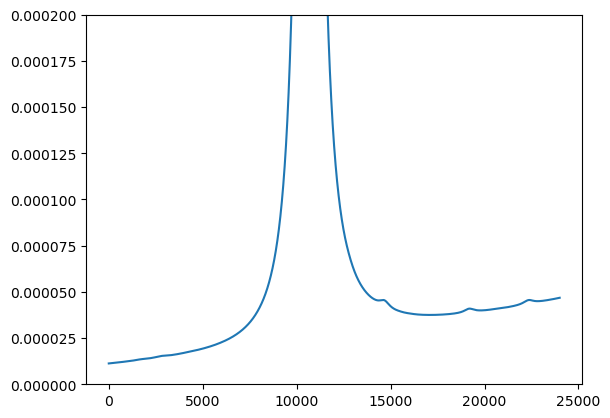

In [5]:
# Import the atm absorption spectrum
abs_spectrum = atm.absorption_spectrum()

plt.plot(abs_spectrum)
plt.ylim(0, 0.0002)

In [6]:
# Import the atm temperature maps
atm_maps = atm.get_temp_maps(atm.rho_map)

# Import the atm integrated absorption spectrum
integrated_abs_spectrum, frequencies = atm.integrated_absorption_spectrum()

Text(0, 0.5, 'Integrated absorption spectrum')

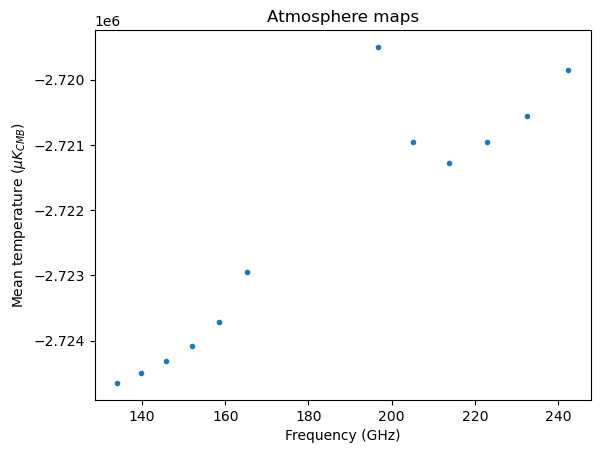

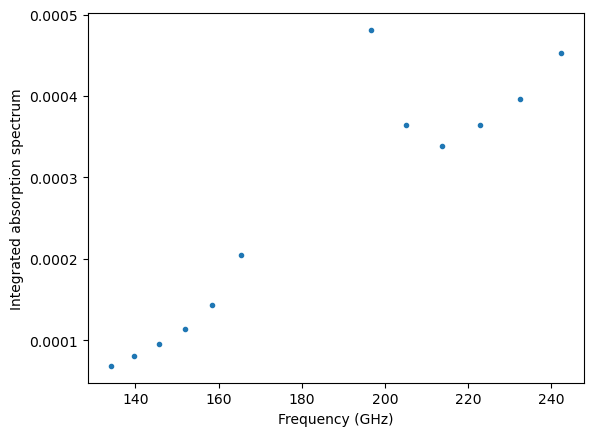

In [7]:
mean_atm_maps = []
for i in range(atm_maps.shape[0]):
    mean_atm_maps.append(np.mean(atm_maps[i, :]))
plt.figure()
plt.plot(frequencies, mean_atm_maps, '.')
plt.title('Atmosphere maps')
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'Mean temperature ($\mu K_{CMB}$)')
plt.figure()
plt.plot(frequencies, integrated_abs_spectrum, '.')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Integrated absorption spectrum')

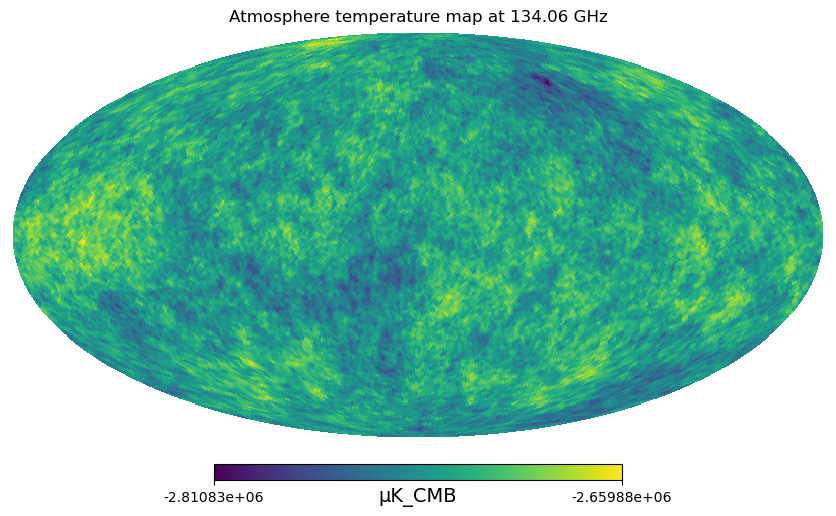

In [8]:
hp.mollview(atm_maps[0], title='Atmosphere temperature map at {:.2f} GHz'.format(frequencies[0]), unit='µK_CMB')

(12, 49152, 3)


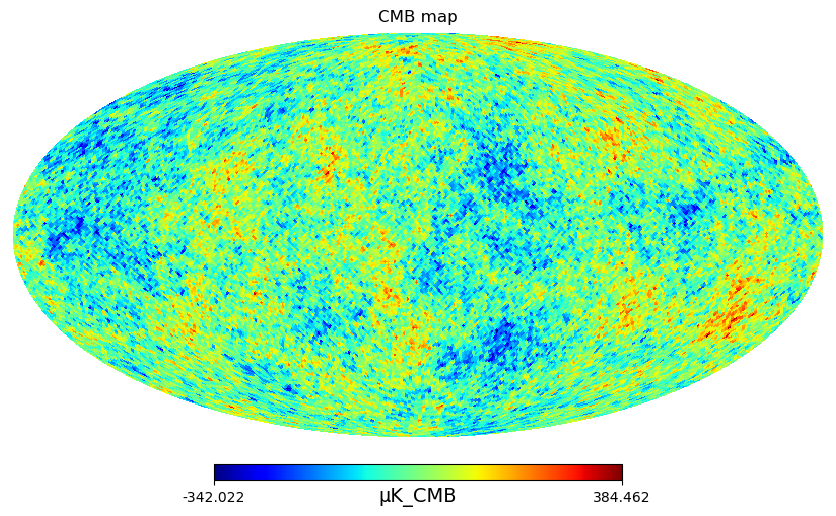

In [9]:
# Import CMB maps
cmb_maps = InputMaps({'cmb':42}, atm.frequencies, 2, params['nside']).m_nu
print(cmb_maps.shape)
hp.mollview(cmb_maps[-1, :, 0],cmap='jet', unit='µK_CMB', title='CMB map')

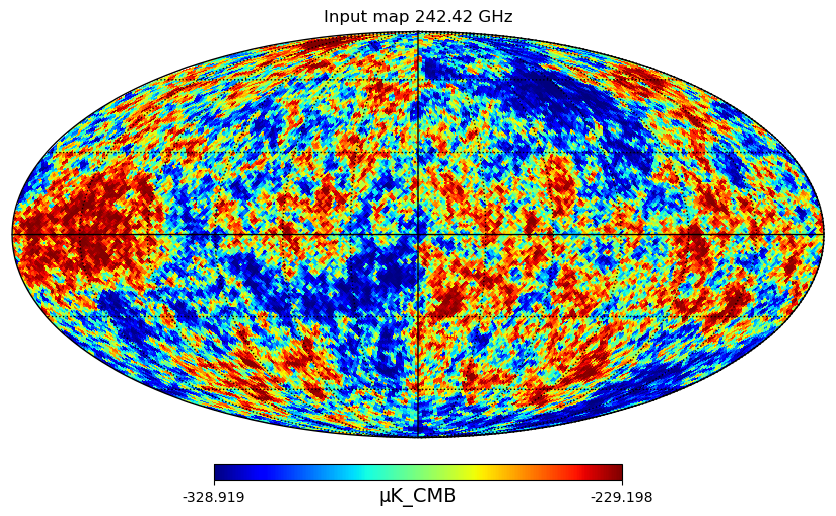

In [10]:
# Build input maps : CMB + Atmsophere (only for I map)
input_maps = cmb_maps.copy()*0
input_maps[:, :, 0] += atm_maps/1e4

hp.mollview(input_maps[-1, :, 0] ,cmap='jet', unit='µK_CMB', norm='hist', title='Input map {:.2f} GHz'.format(frequencies[-1]))
hp.graticule()

# Map-making

In [11]:
# Build the different operators
H_tod = qubic.lib.InstrumentModel.Qacquisition.QubicDualBand(atm.qubic_dict, nsub=params['nsub_in'], nrec=params['nsub_in']).get_operator()
Qacq = qubic.lib.InstrumentModel.Qacquisition.QubicDualBand(atm.qubic_dict, nsub=params['nsub_in'], nrec=params['nrec'])
H_rec = Qacq.get_operator()
invN = Qacq.get_invntt_operator()

You asked 2000 pointings with repeat strategy so I will provide 666 pointings repeated 3 times.
Info apcnb2325: Allocating (1982016,14) elements = 423.404296875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,14) elements = 423.404296875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,14) elements = 423.404296875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,14) elements = 423.404296875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,14) elements = 423.404296875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,14) elements = 423.404296875 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,22) elements = 665.349609375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,22) elements = 665.349609375 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (1982016,22) elements = 665.349609375 MiB in FSRRotation3dMat

In [12]:
#coverage = joint.qubic.subacqs[0].get_coverage()
coverage = Qacq.coverage
npix_qubic=0
for i in coverage:
    if i!=0:
        npix_qubic+=1
covnorm = coverage / coverage.max()
seenpix = covnorm > 0.

center = np.array([0, -57])
qubic_patch = qubic.lib.Qsamplings.equ2gal(center[0], center[1])

In [13]:
print('H_rec', H_rec.shapein, H_rec.shapeout)
print('invN', invN.shapein, invN.shapeout)
R = ReshapeOperator(invN.shapeout, invN.shape[0])
invN = R(invN(R.T))
print('invN', invN.shapein, invN.shapeout)
print('H_tod', H_tod.shapein, H_tod.shapeout)

H_rec (2, 49152, 3) (3964032,)
invN (1984, 1998) (1984, 1998)
invN (3964032,) (3964032,)
H_tod (12, 49152, 3) (1984, 1998)


(2, 49152, 3)


(130.0, 250.0)

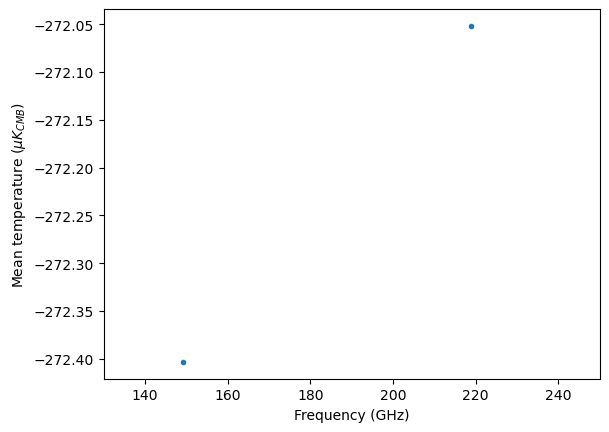

In [14]:
# Compute the Nrec maps from the Nsub maps
true_maps = np.zeros((params['nrec'], 12*params['nside']**2, 3))
true_frequencies = np.zeros(params['nrec'])
fsub = int(params['nsub_in'] / params['nrec'])
for i in range(params['nrec']):
    true_maps[i, :, :] = np.mean(input_maps[i*fsub:(i+1)*fsub, :, :], axis=0)
    true_frequencies[i] = np.mean(frequencies[i*fsub:(i+1)*fsub])
print(true_maps.shape)    
plt.plot(true_frequencies, np.mean(true_maps, axis=1)[..., 0], '.')
plt.ylabel(r'Mean temperature ($\mu K_{CMB}$)')
plt.xlabel('Frequency (GHz)')
plt.xlim(130, 250)

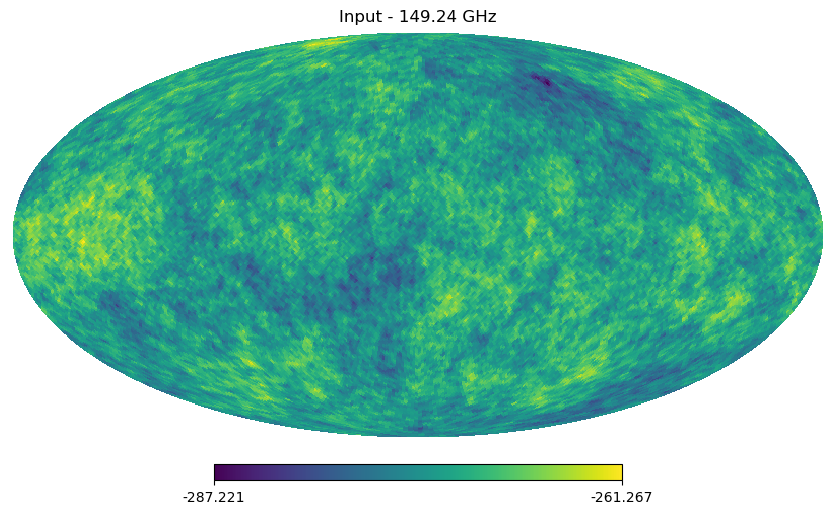

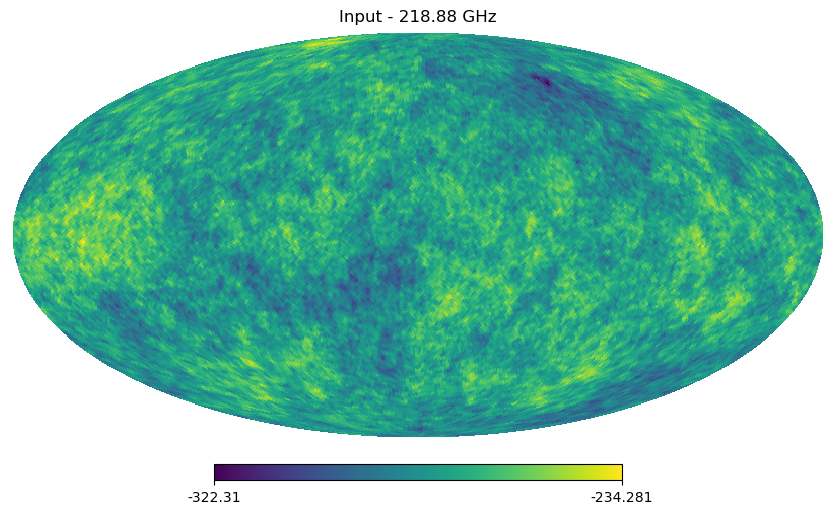

In [15]:
for inu in range(len(true_frequencies)):
    hp.mollview(true_maps[inu, :, 0],title='Input - {:.2f} GHz'.format(true_frequencies[inu]))

In [16]:
# Build PCG
tod = H_tod(input_maps).ravel()
A = H_rec.T * invN * H_rec
b = H_rec.T * invN * tod
x0 = true_maps

In [17]:
print('A', A.shapein, A.shapeout)
print('b', b.shape)

A (2, 49152, 3) (2, 49152, 3)
b (2, 49152, 3)


In [18]:
# Code to compute the preconditioner

approx_hth = np.zeros((x0.shape))
conditioner = np.zeros((x0.shape))
vec = np.ones(Qacq.H[0].shapein)

for i in range(x0.shape[0]):
    for j in range(x0.shape[0]):
        approx_hth[i] = (
            Qacq.H[i].T
            * Qacq.invn220
            * Qacq.H[j](vec)
        )
fsub_out = int(params["nsub_in"] / params["nrec"])
for irec in range(params["nrec"]):
    imin = irec * fsub_out
    imax = (irec + 1) * fsub_out
    for istk in range(3):
        conditioner[irec, seenpix, istk] = 1 / (
            np.sum(approx_hth[imin:imax, seenpix, 0], axis=0)
        )

conditioner[conditioner == np.inf] = 1
M = DiagonalOperator(conditioner)

In [19]:
print(M.shapein, M.shapeout)

(2, 49152, 3) (2, 49152, 3)


In [20]:
# Run PCG
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=50,
    disp=True,
    M=None,
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

 Iter     Tol      time
   1: 1.5615e-04 2.41397 [5.70845382e-03 5.42723759e-17 5.28417278e-17 6.54858523e-02
 1.62812628e-16 1.62244863e-16]
   2: 6.3064e-05 2.46395 [1.45539971e-02 1.54587461e-16 1.50535157e-16 1.13269564e-01
 4.34882737e-16 4.34197097e-16]
   3: 2.9046e-05 2.30682 [2.48543253e-02 3.26878891e-16 3.18423440e-16 1.37557998e-01
 8.01182291e-16 8.03210739e-16]
   4: 1.7722e-05 2.42281 [3.12846311e-02 5.01049410e-16 4.88360963e-16 1.46402705e-01
 1.04325437e-15 1.05074904e-15]
   5: 1.3528e-05 2.49538 [3.79576583e-02 7.32183258e-16 7.14271956e-16 1.52564772e-01
 1.28927731e-15 1.30413813e-15]
   6: 9.4824e-06 2.30271 [4.26985230e-02 9.46429751e-16 9.24260701e-16 1.57117937e-01
 1.49766901e-15 1.51874658e-15]
   7: 7.6285e-06 2.77643 [4.53737942e-02 1.14153065e-15 1.11641834e-15 1.60789722e-01
 1.68886267e-15 1.71576574e-15]
   8: 5.9238e-06 2.84886 [4.68983376e-02 1.31258206e-15 1.28598602e-15 1.63966340e-01
 1.87690896e-15 1.90978034e-15]
   9: 5.5621e-06 2.92221 [4.8149

Text(0, 0.5, 'Convergence')

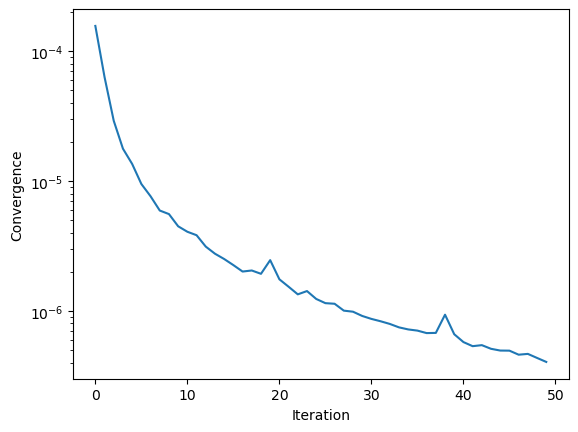

In [21]:
plt.plot(output['convergence'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

In [22]:
stokes = ['I', 'Q', 'U']

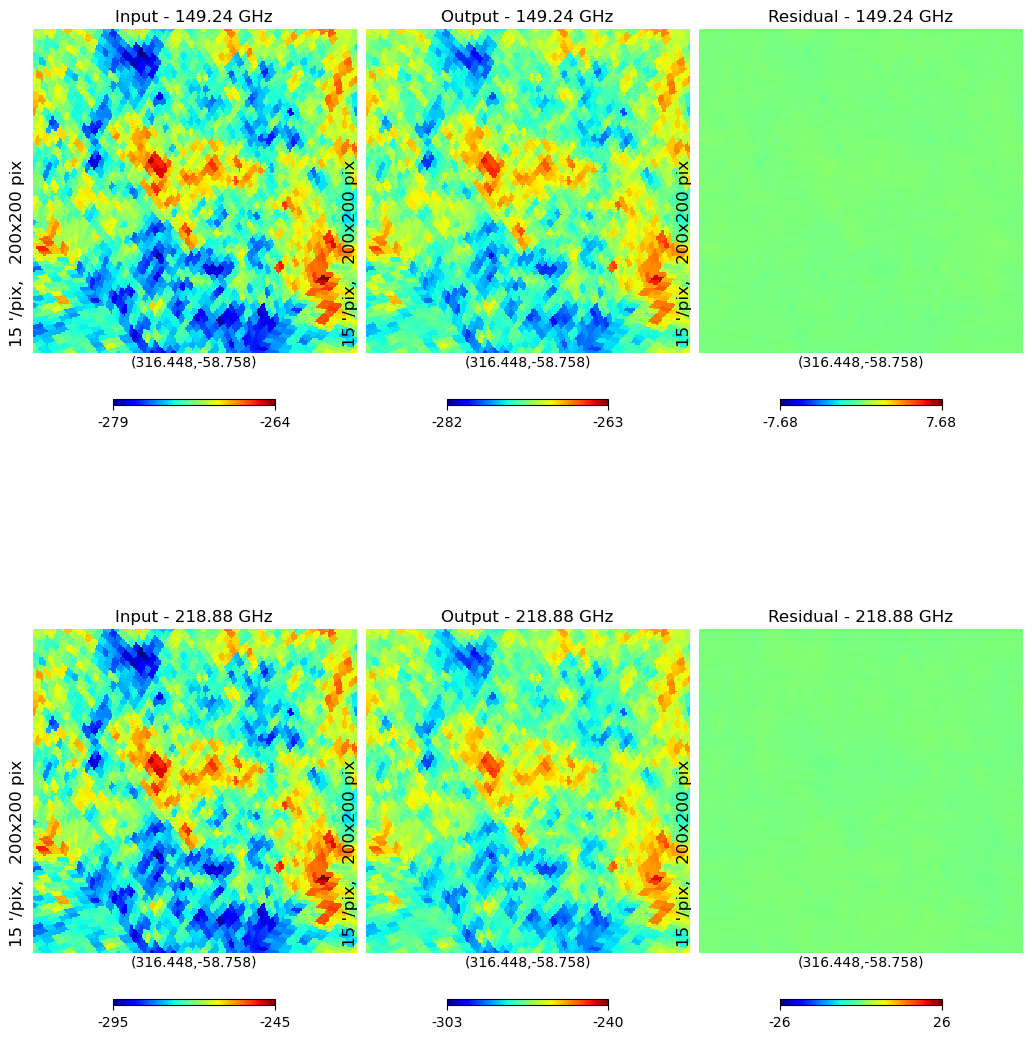

In [23]:
plt.figure(figsize=(10, 12))
k=1
true_maps[:, ~seenpix, :] = 0
output['x'][:, ~seenpix, :] = 0

istk = 0
n_sig = 3

for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.gnomview(true_maps[inu, :, istk], cmap='jet', rot=qubic_patch,title='Input - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k))
    hp.gnomview(output['x'][inu, :, istk], min=np.min(true_maps[inu, seenpix, istk]), max=np.max(true_maps[inu, seenpix, istk]), cmap='jet', rot=qubic_patch,title='Output - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+1))
    hp.gnomview(output['x'][inu, :, istk] - true_maps[inu, :, 0], min=-n_sig*sigma, max=n_sig*sigma, cmap='jet', rot=qubic_patch,title='Residual - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+2))
    k+=3

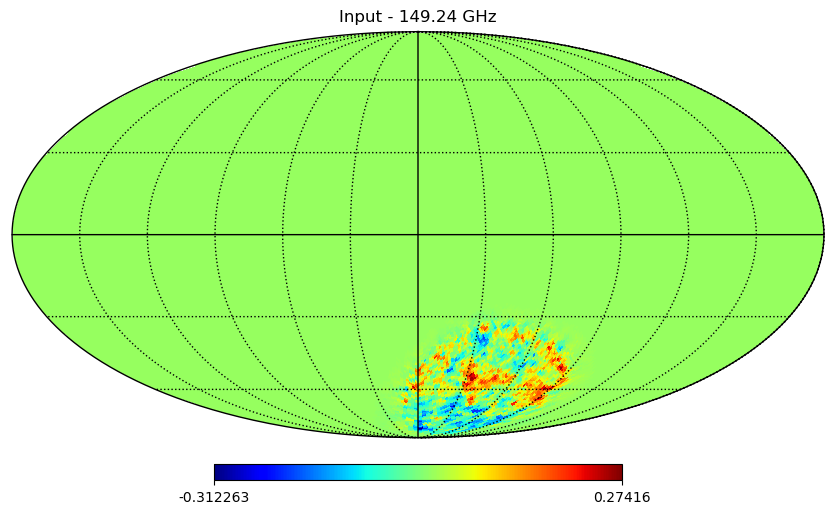

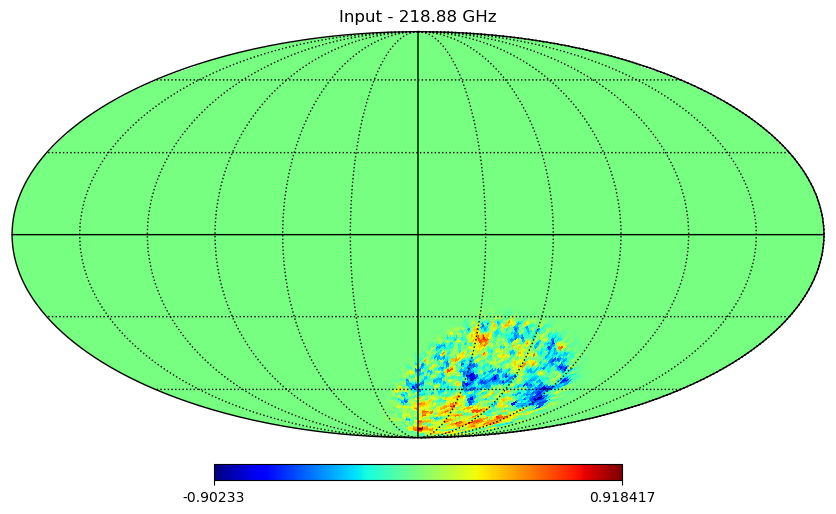

In [24]:
for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.mollview(output['x'][inu, :, istk] - true_maps[inu, :, istk], cmap='jet',title='Input - {:.2f} GHz'.format(true_frequencies[inu]))
    hp.graticule()

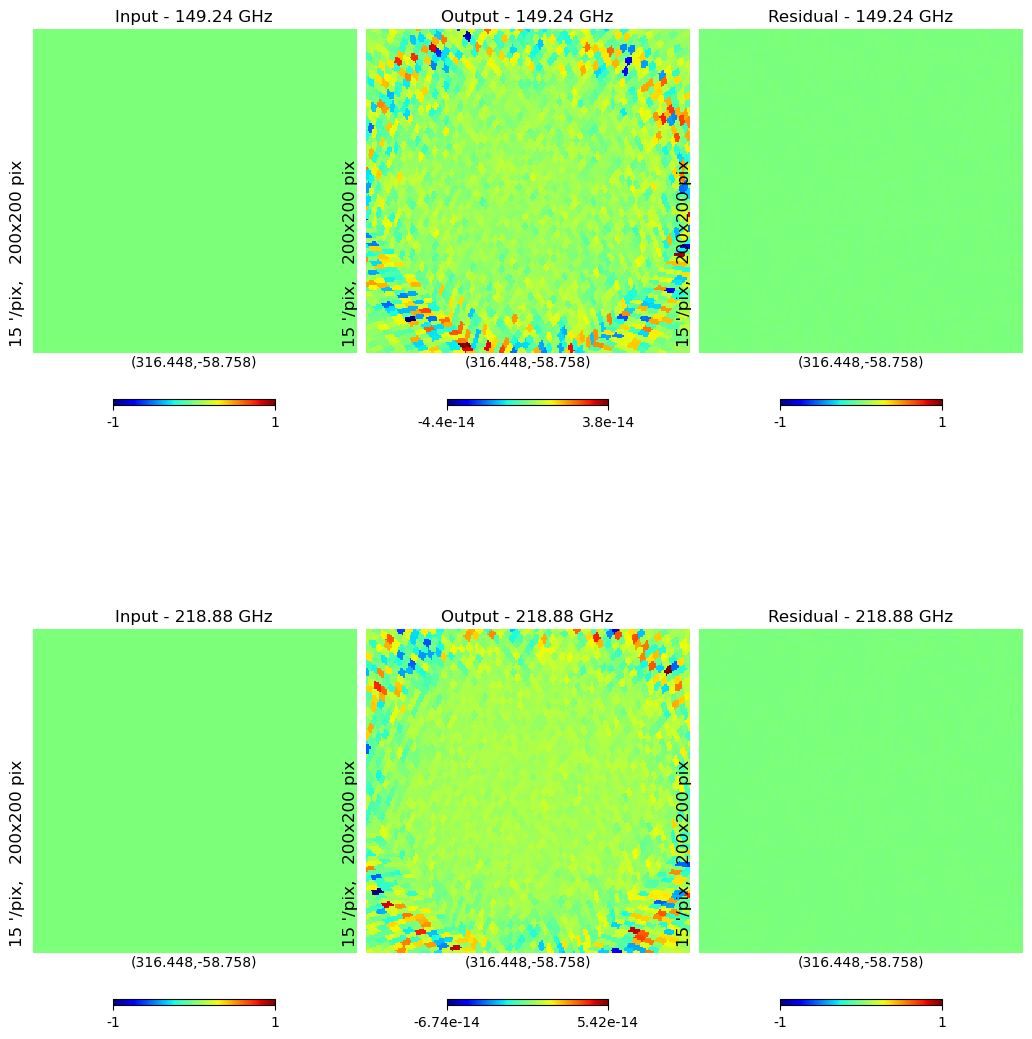

In [25]:
plt.figure(figsize=(10, 12))

k=1
true_maps[:, ~seenpix, :] = hp.UNSEEN
output['x'][:, ~seenpix, :] = hp.UNSEEN

istk = 1
n_sig = 2

for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.gnomview(true_maps[inu, :, istk], cmap='jet', rot=qubic_patch,title='Input - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k))
    hp.gnomview(output['x'][inu, :, istk], cmap='jet', rot=qubic_patch,title='Output - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+1))
    hp.gnomview(output['x'][inu, :, istk] - true_maps[inu, :, istk], min=-n_sig*sigma, max=n_sig*sigma, cmap='jet', rot=qubic_patch,title='Residual - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+2))
    k+=3

In [26]:
stop

NameError: name 'stop' is not defined

In [13]:
from lib.InstrumentModel.Qacquisition import QubicMultiAcquisitions

ModuleNotFoundError: No module named 'lib'